In [1]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (12, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
from cryptocmd import CmcScraper
import talib

start_date = "31-03-2020"
end_date = "31-03-2022"
symbol = "ETH"

In [3]:
df = CmcScraper(symbol, start_date=start_date, end_date=end_date).get_dataframe().set_index("Date").sort_index(0)
df = df.reset_index()
df["Percent Change"] = df["Close"] / df["Open"]
df["Moving"] = np.where(df["Percent Change"] > 1, 1, 0)
df["Varince"] = df["High"] - df["Low"]
df["RSI"] = talib.RSI(df["Close"])
df["OBV"] = talib.OBV(df["Close"], df["Volume"])
df["A/D Line"] = talib.AD(df["High"], df["Low"], df["Close"], df["Volume"])
df["MACD"], df["MACD-signal"], df["MACD-hist"] = talib.MACD(df["Close"])

/var/folders/jn/5rwzylmj2kz6wnd9vy4t2lhh0000gn/T/ipykernel_49453/3374468197.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  df = CmcScraper(symbol, start_date=start_date, end_date=end_date).get_dataframe().set_index("Date").sort_index(0)


In [4]:
df.dropna(inplace=True)
df = df.reset_index().drop('index', axis=1)
date = pd.to_datetime(df.pop('Date'))

In [5]:
np.asarray([ df.T[i] for i in range(len(df)) ]).shape

(698, 15)

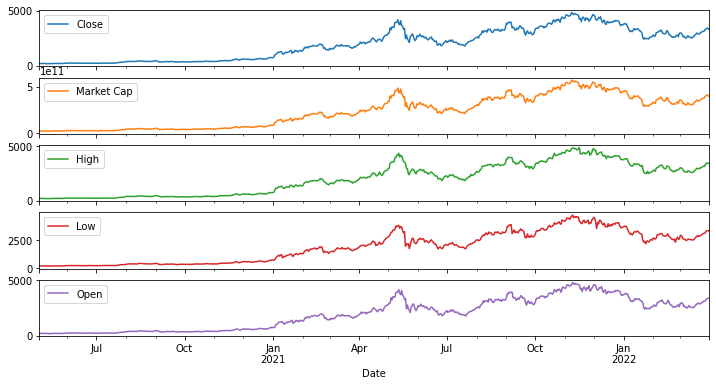

In [6]:
plot_cols = ['Close', 'Market Cap', 'High', 'Low', 'Open']
plot_features = df[plot_cols]
plot_features.index = date
_ = plot_features.plot(subplots=True)

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,698.0,1.956671e+03,1.387801e+03,1.858773e+02,4.128561e+02,1.985301e+03,3.107938e+03,4.810072e+03
High,698.0,2.023296e+03,1.429332e+03,1.913623e+02,4.218624e+02,2.043823e+03,3.201518e+03,4.891705e+03
Low,698.0,1.882766e+03,1.339166e+03,1.807183e+02,4.004768e+02,1.904431e+03,3.002422e+03,4.718039e+03
Close,698.0,1.960573e+03,1.386295e+03,1.859128e+02,4.138466e+02,1.990354e+03,3.118972e+03,4.812088e+03
Volume,698.0,2.082975e+10,1.132937e+10,5.109033e+09,1.320291e+10,1.792416e+10,2.551322e+10,8.448291e+10
Market Cap,698.0,2.297966e+11,1.647282e+11,2.061570e+10,4.676242e+10,2.320729e+11,3.696606e+11,5.690943e+11
Percent Change,698.0,1.004985e+00,4.896195e-02,7.274397e-01,9.797243e-01,1.005389e+00,1.032410e+00,1.259513e+00
Moving,698.0,5.515759e-01,4.976894e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
Varince,698.0,1.405300e+02,1.405858e+02,2.305099e+00,2.639789e+01,1.201362e+02,1.959007e+02,1.485476e+03
RSI,698.0,5.597332e+01,1.225330e+01,2.161581e+01,4.687796e+01,5.577596e+01,6.459591e+01,9.032818e+01


In [8]:
selected_feature = ['Close', 'Market Cap', 'High', 'Low', 'Open']
target = "Close"

column_indices = {name: i for i, name in enumerate(df.columns)}

split_portion = (0.6, 0.20)

n = len(df)
train_df = df[selected_feature][: int(n * split_portion[0])]
val_df = df[selected_feature][int(n * split_portion[0]) : -int(n * split_portion[-1])]
test_df = df[selected_feature][-int(n * split_portion[-1]) :]

num_features = df[selected_feature].shape[1]

train_df.shape, val_df.shape, test_df.shape, num_features

((418, 5), (141, 5), (139, 5), 5)

In [9]:
train_df.reset_index().drop("index", axis=1).T[0]

Close         2.109332e+02
Market Cap    2.336718e+10
High          2.192709e+02
Low           2.086924e+02
Open          2.153521e+02
Name: 0, dtype: float64

In [10]:
class StandardScaler():
    
    def fit(self, fit_data):
        self.fit_data = fit_data
        self.fit_mean = fit_data.mean()
        self.fit_std = fit_data.std()
        
    def transform(self, data):
        return (data - self.fit_mean) / self.fit_std
    
    def inverse_transform(self, trans_data):
        return trans_data * self.fit_std + self.fit_std
    
    def fit_transform(self, fit_data):
        self.fit(fit_data)
        return self.transform(fit_data)

In [11]:
class MinMaxScaler():
    
    def __init__(self, scale_range=(0, 1)):
        self.a, self.b = scale_range
    
    def fit(self, fit_data):
        self.fit_data = fit_data
        self.fit_min = fit_data.min()
        self.fit_max = fit_data.max()
        
    def transform(self, data):
        return self.a + ((data - self.fit_min)*(self.b - self.a)) / (self.fit_max - self.fit_min)
    
    def inverse_transform(self, trans_data):
        return (trans_data - self.a) * (self.fit_max - self.fit_min) / ((trans_data - self.fit_min)*(self.b - self.a))
    
    def fit_transform(self, fit_data):
        self.fit(fit_data)
        return self.transform(fit_data)

In [12]:
scale_range = train_df.max() - train_df.min()
scale_range["Close"]

3982.7882117000004

In [13]:
# scaler = StandardScaler()
scaler = MinMaxScaler()

train_df = scaler.fit_transform(train_df)
val_df = scaler.transform(val_df)
test_df = scaler.transform(test_df)

In [14]:
train_df

,Close,Market Cap,High,Low,Open
0,0.006282,0.005952,0.006691,0.007760,0.007389
1,0.005589,0.005297,0.004907,0.005084,0.006271
2,0.005238,0.004968,0.004895,0.006467,0.005550
3,0.004555,0.004322,0.004836,0.006469,0.005166
4,0.006623,0.006302,0.005522,0.005924,0.004522
...,...,...,...,...,...
413,0.517339,0.520915,0.499647,0.518496,0.497764
414,0.427473,0.430865,0.495830,0.467796,0.516311
415,0.424084,0.427522,0.431983,0.423530,0.426396
416,0.452905,0.456468,0.444060,0.456808,0.424380


In [15]:
from window import WindowGenerator

WIDTH = 30
OFFSET = 2

wide_window = WindowGenerator(
    train_df=train_df, val_df=val_df, test_df=test_df,
    input_width=WIDTH, label_width=WIDTH, shift=OFFSET,
    label_columns=[target]
)
wide_window

Window size: 32
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31]
Label column name(s): ['Close']

In [16]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=10, max_epochs=MAX_EPOCHS):
    # early_stopping = tf.keras.callbacks.EarlyStopping(
    #     monitor='val_loss', patience=patience, mode='min'
    # )
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(learning_rate=0.001),
                  metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=max_epochs,
                        validation_data=window.val,
                        # callbacks=[early_stopping]
                        )
    
    return history

In [17]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(12, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

2022-05-20 06:12:28.910031: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
print(f'Input shape: {wide_window.example[0].shape}')
print(f'Output shape: {lstm_model(wide_window.example[0]).shape}')

Input shape: (30, 30, 5)
Output shape: (30, 30, 1)


In [19]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance = lstm_model.evaluate(wide_window.val)
performance = lstm_model.evaluate(wide_window.test, verbose=0)

4/4 [==============================] - 0s 14ms/step - loss: 0.0063 - mean_absolute_error: 0.0636


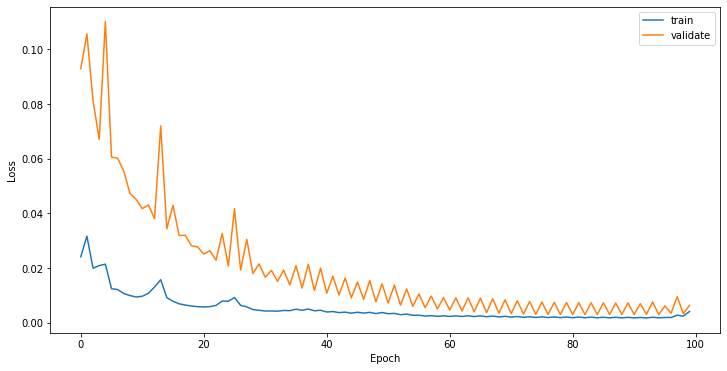

In [20]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history['val_loss'], label="validate")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

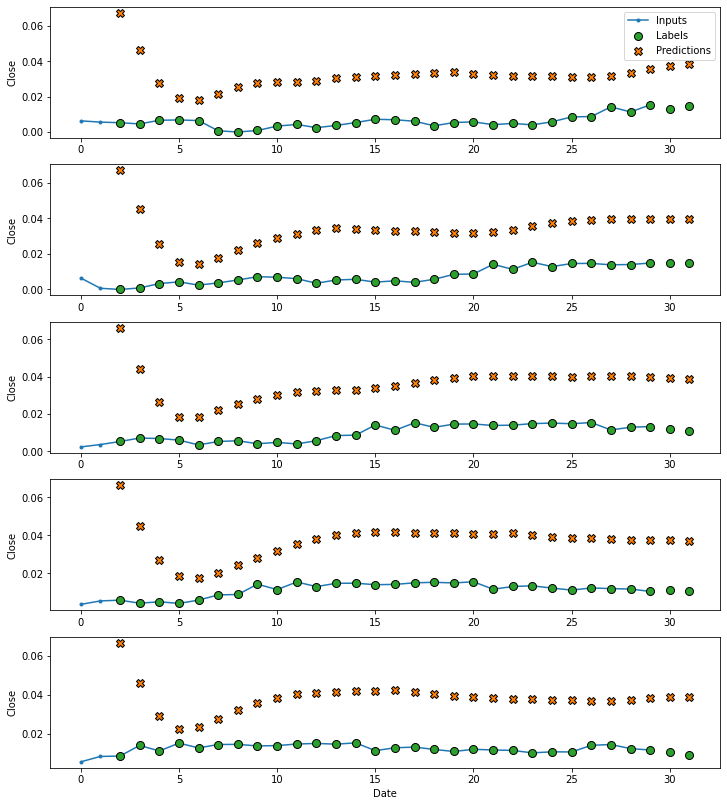

In [21]:
wide_window.plot(plot_col=target, model=lstm_model, max_subplots=5)

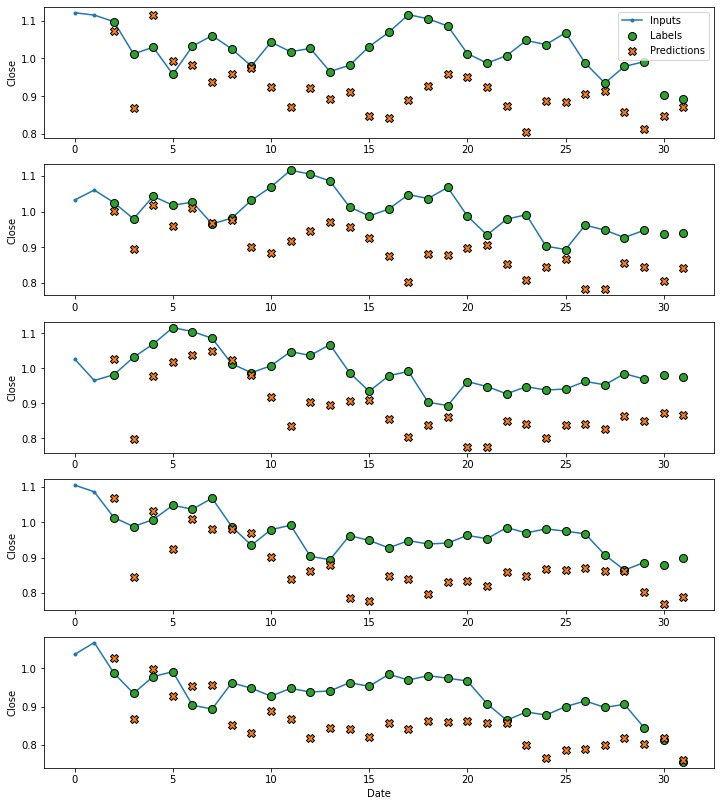

In [22]:
wide_window.plot(plot_col=target, model=lstm_model, example=wide_window.test, max_subplots=5)

In [23]:
print('Validation Loss')
print(f'MSE: {val_performance[0]}, MAE: {val_performance[1]}')
print('Test Loss')
print(f'MSE: {performance[0]}, MAE: {performance[1]}')

Validation Loss
MSE: 0.006298257503658533, MAE: 0.06360317021608353
Test Loss
MSE: 0.005713766440749168, MAE: 0.058659832924604416


In [24]:
(val_performance[1] * scale_range)["Close"], (performance[1] * scale_range)["Close"]

(253.31795656336604, 233.62969107240602)

Window size: 44
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43]
Label column name(s): None

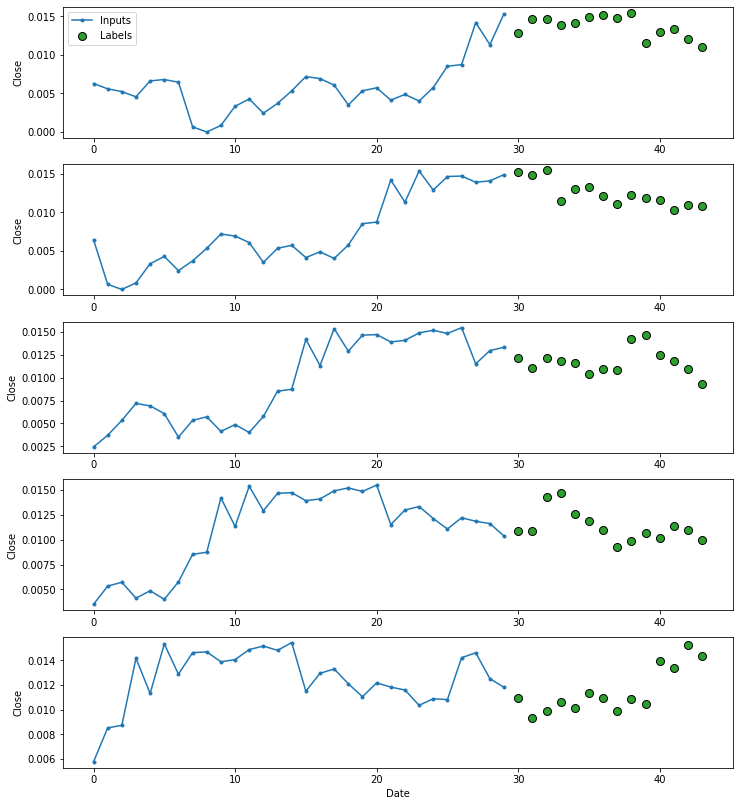

In [25]:
OUT_STEPS = 14
muti_window = WindowGenerator(
    test_df=test_df, val_df=val_df, train_df=train_df,
    input_width=30,
    label_width=OUT_STEPS,
    shift=OUT_STEPS
)
muti_window.plot(plot_col=target, max_subplots=5)
muti_window

In [26]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(12, return_sequences=False),
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

print(f'Input shape: {muti_window.example[0].shape}')
print(f'Output shape: {multi_lstm_model(muti_window.example[0]).shape}')

Input shape: (30, 30, 5)
Output shape: (30, 14, 5)


4/4 [==============================] - 0s 10ms/step - loss: 0.0548 - mean_absolute_error: 0.2064


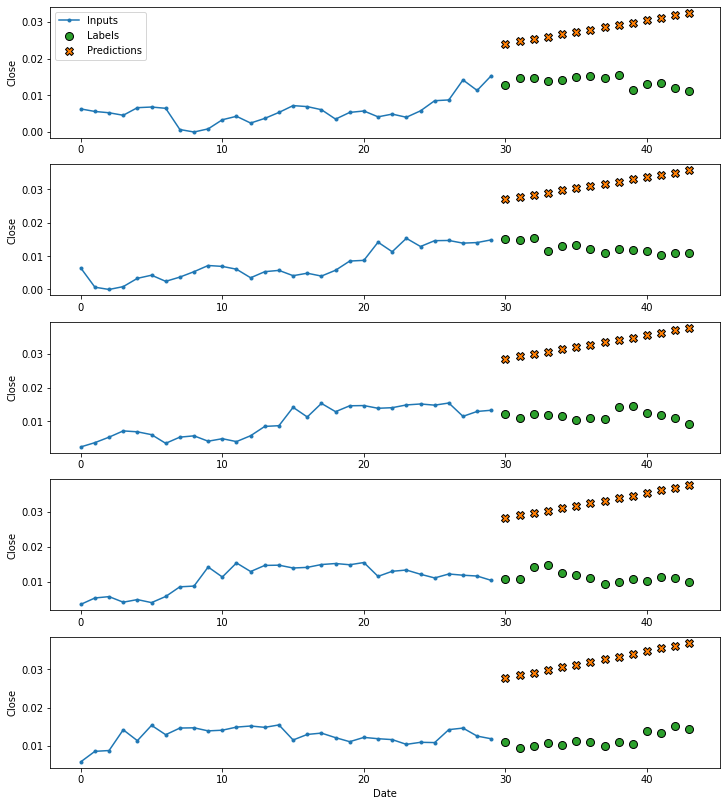

In [27]:
history = compile_and_fit(multi_lstm_model, muti_window)

IPython.display.clear_output()
multi_val_performance = multi_lstm_model.evaluate(muti_window.val)
multi_performance = multi_lstm_model.evaluate(muti_window.test, verbose=0)
muti_window.plot(plot_col=target, model=multi_lstm_model, max_subplots=5)

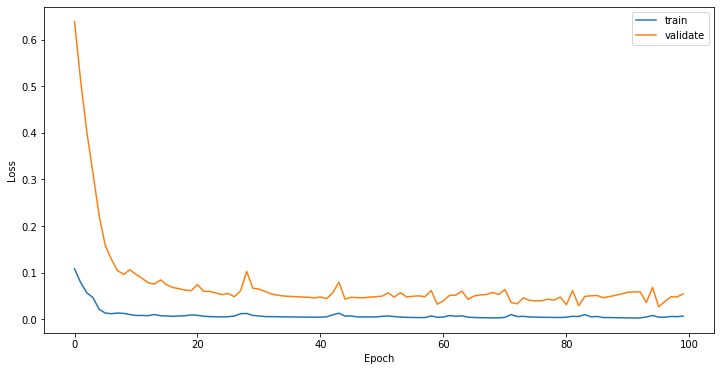

In [28]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history['val_loss'], label="validate")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

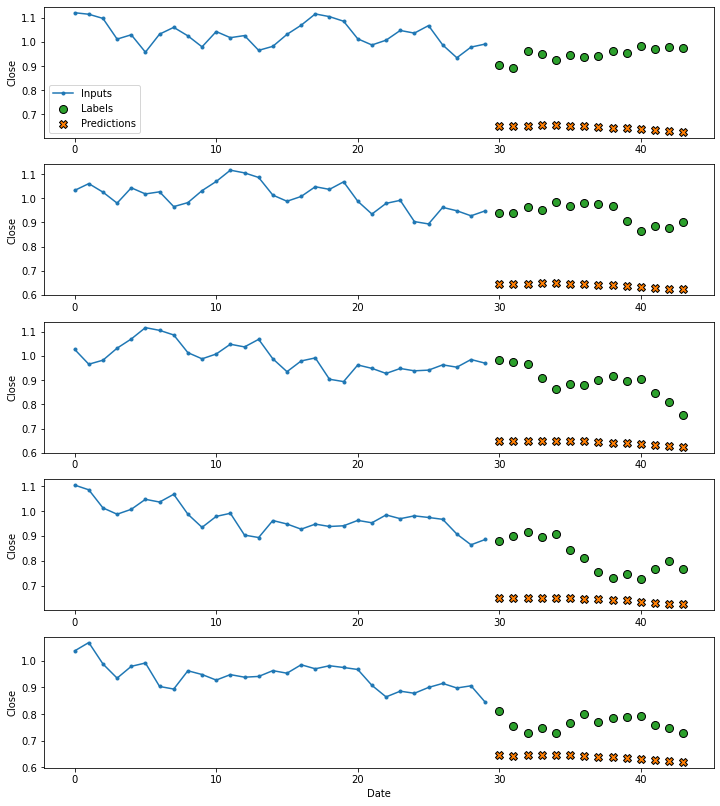

In [29]:
muti_window.plot(plot_col=target, example=muti_window.test, model=multi_lstm_model, max_subplots=5)

In [30]:
print("Validation")
print(f'Loss: {multi_val_performance[0]}, MAE: {multi_val_performance[1]}')
print("Test")
print(f'Loss: {multi_performance[0]}, MAE: {multi_performance[1]}')

Validation
Loss: 0.054833076894283295, MAE: 0.2064085602760315
Test
Loss: 0.022400567308068275, MAE: 0.11069229990243912


In [31]:
(multi_val_performance[1] * scale_range)["Close"], (multi_performance[1] * scale_range)["Close"]

(822.0815806613472, 440.86398717739564)